# &#x1F4F6; [Demodulation of the 5G NR downlink](https://destevez.net/2023/08/demodulation-of-the-5g-nr-downlink/)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
x = np.fromfile('catkira/1876954_7680KSPS_srsRAN_Project_gnb_short.sigmf-data', 'int32')
fs = 7_680_000
# This should be the nominal RF frequency of the subcarrier that we use as DC for demodulation
# (used for NR phase compensation)
f_dc = 1_876_950_000

# these are in units of samples and depend on fs
Tu = 512
Ncp = 144 // 4
Ncpl = (144 + 16) // 4

cfo = 18.88  # Hz
phi0 = -2.97  # radians
sfo = -3.2e-6  # parts per one
sto_fine = 12.4e-9  # seconds

In [3]:
display(len(x),x[0]);

2200544

106496

In [4]:
# phase correction to apply to symbols 0, 1, 2, 3, 4, 5, 6 in a 0.5 ms interval
p_0 = f_dc * (np.arange(7) * (Tu + Ncp)) / fs
p_1 = p_0 % 1
phase_corr = np.exp(1j*2*np.pi*p_1)
display(phase_corr)

array([ 1.        +0.j        ,  0.29028468+0.95694034j,
       -0.83146961+0.55557023j, -0.77301045-0.63439328j,
        0.38268343-0.92387953j,  0.99518473+0.09801714j,
        0.19509032+0.98078528j])

In [5]:
# Amplitude adjustment to get symbols of unity amplitude
x = (x[::2] + 1j * x[1::2]) / 2**31 * 24.7; display(x[0])

(0.0012248992919921874+0.00023555755615234375j)

In [6]:
# correct for CFO and phase offset
x *= np.exp(-1j*(2*np.pi*cfo/fs*np.arange(x.size) + phi0)); display(x[0])

(-0.0012471323880128085-2.2944379549165977e-05j)

In [7]:
# Pseudo-random sequence
def c_seq(init, length):
    crop = 1600
    x1 = np.zeros(crop + length, 'uint8')
    x2 = np.zeros(crop + length, 'uint8')
    x1[0] = 1
    j = 0
    for j in range(31):
        x2[j] = (init >> j) & 1
    for j in range(x1.size - 31):
        x1[j + 31] = x1[j + 3] ^ x1[j]
        x2[j + 31] = x2[j + 3] ^ x2[j + 2] ^ x2[j + 1] ^ x2[j]
    return x1[crop:] ^ x2[crop:]

In [8]:
def plot_ref(ref, ax=None, refscale=1):
    const = {'bpsk': [-1, 1], 'pilot': [1],
             'qpsk': [np.exp(1j*(np.pi/2*k + np.pi/4)) for k in range(4)]}[ref]
    const = np.array(const)
    const = const * refscale
    if ax is None:
        ax = plt
    ax.plot(const.real, const.imag, '.', color='red', markersize=3)

def constellation_plot(z, title=None, ref='bpsk', ax=None, refscale=1, **kwargs):
    if ax is None:
        plt.figure(figsize=(2.5, 2.5))
        ax = plt.gca()
    ax.plot(z.real, z.imag, '.', **kwargs)
    plot_ref(ref, ax, refscale)
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title);

## Poor man's Schmidl & Cox

In [9]:
cp_corr = np.zeros(round(fs * 0.4e-3), 'complex'); display(len(cp_corr))
corr_start = round(9.05e-3 * fs); display(corr_start)
for j in range(cp_corr.size):
    y = x[corr_start + j:][:Ncp+Tu]
    cp_corr[j] = np.sum(y[:Ncp] * np.conjugate(y[-Ncp:]))

t_corr = 1e3 * (np.arange(cp_corr.size) + corr_start) / fs; display(t_corr[0])

3072

69504

9.05

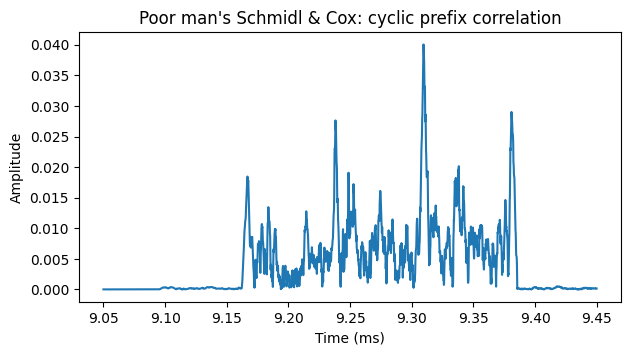

In [10]:
plt.plot(t_corr, np.abs(cp_corr))
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title("Poor man's Schmidl & Cox: cyclic prefix correlation");

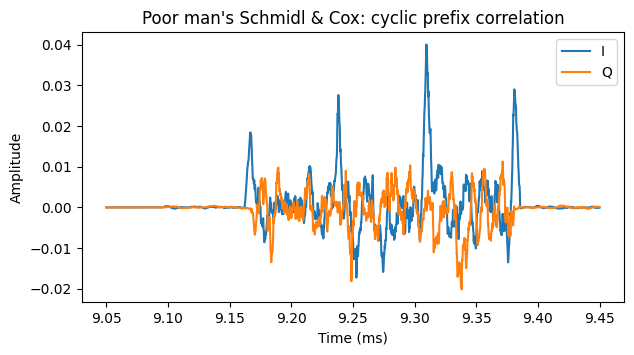

In [11]:
plt.plot(t_corr, np.real(cp_corr))
plt.plot(t_corr, np.imag(cp_corr))
plt.legend(['I', 'Q'])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title("Poor man's Schmidl & Cox: cyclic prefix correlation");

In [12]:
m0 = np.argmax(np.abs(cp_corr[:1000]))
m1 = np.argmax(np.abs(cp_corr[1000:1500])) + 1000
m2 = np.argmax(np.abs(cp_corr[1500:2250])) + 1500
m3 = np.argmax(np.abs(cp_corr[2250:])) + 2250

In [13]:
display([m0, m1, m2, m3]);
display(cp_corr[[m0, m1, m2, m3]])
display(fs / Tu); 

[897, 1445, 1993, 2541]

array([0.01845336-3.25952312e-04j, 0.02763091+7.18219761e-05j,
       0.04004619-9.26536916e-05j, 0.02900743-5.10967299e-04j])

15000.0

In [14]:
# CFO estimates (Hz)
-np.angle(cp_corr[[m0, m1, m2, m3]]) / (2 * np.pi) * (fs / Tu)

array([42.16428531, -6.20544002,  5.52347131, 42.04848156])

## PSS demodulation

In [15]:
# start demodulation at the middle of the cyclic prefix for maximum robustness to STO
a0 = corr_start + m0 + Ncp // 2; display(a0, " = ", corr_start, " + ", m0, " + ", Ncp//2)

f = np.fft.fftshift(np.fft.fft(x[a0:a0+Tu])); display(f[0])
# correct for the 5G NR upconversion discontinuity
# this PSS is transmitted on symbol 2 mod 7
f *= [phase_corr[2]]; display(phase_corr[2], f[0])
# correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*Ncp/2); display(f[0])

70419

' = '

69504

' + '

897

' + '

18

(-0.0010115171292285896+0.004078899947208892j)

(-0.8314696123025453+0.5555702330196022j)

(-0.0014250696388574077-0.003953450164915497j)

(-0.001425069638857399-0.0039534501649155j)

In [16]:
# The PSS ocuppies subcarriers 56 to 128 relative to the start of an SS/PBCH block
# In this case, the SS/PBCH block starts at subcarrier -120 (with respect to the
# subcarrier we have decided to treat as DC). This means that the SS/PBCH block is
# not centred with respect to this choice of DC (but this doesn't matter).
pss_sc_sel = range(Tu//2-120+56, Tu//2-120+56+127); display(pss_sc_sel)

range(192, 319)

In [17]:
x_all_sc = np.arange(f.size) - Tu//2; y_all_sc = 10*np.log10(np.abs(f)**2); display(len(x_all_sc))

512

In [18]:
x_pss_sc = np.arange(f.size)[pss_sc_sel] - Tu//2; y_pss_sc = 10*np.log10(np.abs(f[pss_sc_sel])**2); display(x_pss_sc[0],y_pss_sc[0]);

-64

0.27802604993433144

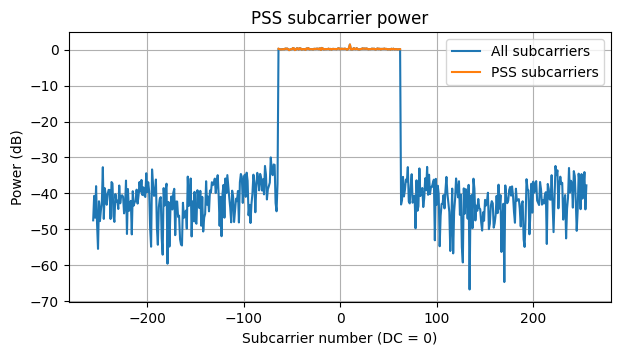

In [19]:
plt.plot(x_all_sc, y_all_sc )
plt.plot(x_pss_sc,y_pss_sc)
plt.title('PSS subcarrier power')
plt.xlabel('Subcarrier number (DC = 0)')
plt.ylabel('Power (dB)')
plt.legend(['All subcarriers', 'PSS subcarriers'])
plt.grid();

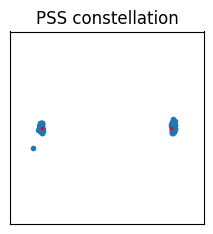

In [20]:
pss_sym_demod = f[pss_sc_sel]
constellation_plot(pss_sym_demod, 'PSS constellation')

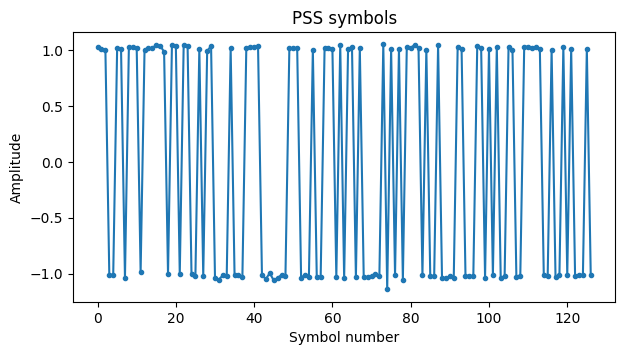

In [21]:
plt.plot(pss_sym_demod.real, '.-')
plt.title('PSS symbols')
plt.xlabel('Symbol number')
plt.ylabel('Amplitude');

In [22]:
def pss_sequence(nid2):
    x = np.zeros(127, 'uint8')
    x[:7] = [1, 1, 1, 0, 1, 1, 0][::-1]
    for j in range(127 - 7):
        x[j + 7] = x[j + 4] ^ x[j]
    return 1 - 2 * x[(np.arange(127) + 43 * nid2) % 127].astype('float')

In [23]:
display(pss_sequence(1))

array([ 1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,
        1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
        1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
       -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
        1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1.,
       -1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,
       -1., -1.,  1., -1.,  1., -1., -1., -1.,  1., -1.])

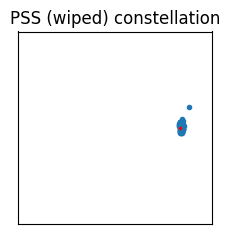

In [24]:
pss_sym_demod_wipe = pss_sym_demod * pss_sequence(1)

constellation_plot(pss_sym_demod_wipe, 'PSS (wiped) constellation', ref='pilot')

In [25]:
# phase error
np.angle(np.average(pss_sym_demod_wipe))

0.002692010414608272

## PSS time domain correlation

67200

array([-2.95147277e-04-2.39155868e-05j,  3.65214358e-05-2.55577623e-04j,
        2.26912853e-04-5.39188365e-04j,  2.42200514e-04-8.00734026e-04j,
        1.01033309e-04-9.74203155e-04j, -1.26212639e-04-1.01738021e-03j,
       -3.44281799e-04-9.28325678e-04j, -4.62152450e-04-7.50406761e-04j,
       -4.23764638e-04-5.52919307e-04j])

67200

array([-0.00060745-0.00021953j, -0.00040881-0.00038843j,
       -0.00026744-0.00055438j, -0.00021424-0.00066727j,
       -0.00022688-0.00070981j, -0.00025693-0.00068902j,
       -0.00026774-0.00064416j, -0.00022993-0.00062184j,
       -0.00013315-0.00064024j])

67200

array([-0.00040409-0.0002577j , -0.00042175-0.00036856j,
       -0.00046552-0.00043575j, -0.00050913-0.00047829j,
       -0.00054653-0.00051373j, -0.00056336-0.00055331j,
       -0.00053087-0.0005866j , -0.00043216-0.00060111j,
       -0.00027056-0.00059923j])

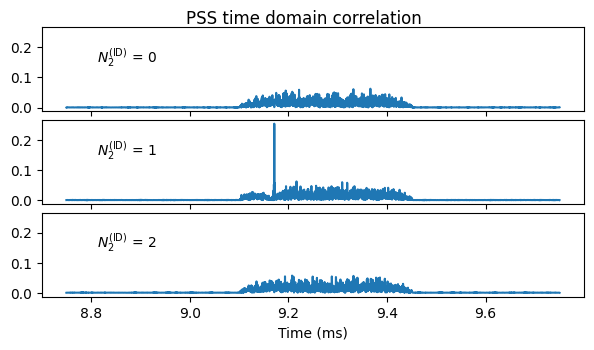

In [26]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)

for nid2 in range(3):
    pss_re = np.zeros(Tu, 'complex')
    pss_re[pss_sc_sel] = pss_sequence(nid2)
    pss_sym = np.fft.ifft(np.fft.fftshift(pss_re)); # display(pss_sym[0:9]);
    pss_corr = np.zeros(round(fs * 1e-3), 'complex')
    time_corr_start = round(8.75e-3 * fs); display(time_corr_start); # display(pss_corr.size)
    for j in range(pss_corr.size):
        pss_corr[j] = np.sum(x[time_corr_start + j:][:Tu] * np.conjugate(pss_sym))
    tcorr = 1e3*(time_corr_start + np.arange(pss_corr.size))/fs; # display(tcorr, len(tcorr))
    axs[nid2].plot(tcorr, np.abs(pss_corr)); display(pss_corr[0:9]);
    axs[nid2].text(tcorr[pss_corr.size//16], 0.15, f'$N^{{\mathrm{{(ID)}}}}_2$ = {nid2}')

plt.subplots_adjust(hspace=0.1)
plt.suptitle('PSS time domain correlation', y=0.93)
axs[-1].set_xlabel('Time (ms)');

In [27]:
NID2 = 1

In [28]:
def sss_sequence(nid1, nid2, only_x1=False, no_x1=False):
    x0 = np.zeros(127, 'uint8')
    x1 = np.zeros(127, 'uint8')
    x0[0] = 1
    x1[0] = 1
    for j in range(127 - 7):
        x0[j + 7] = x0[j + 4] ^ x0[j]
        x1[j + 7] = x1[j + 1] ^ x1[j]
    if only_x1:
        return 1 - 2 * x1.astype('float')
    m0 = 15 * (nid1 // 112) + 5 * nid2
    m1 = nid1 % 112
    if no_x1:
        return 1 - 2 * x0[(np.arange(127) + m0) % 127].astype('float')
    return ((1 - 2 * x0[(np.arange(127) + m0) % 127].astype('float')) *
            (1 - 2 * x1[(np.arange(127) + m1) % 127].astype('float')))

## SSS demodulation

In [29]:
sss_part = x[a0+2*(Ncp + Tu):][:Tu]; display(sss_part[0],len(sss_part))

(3.085366650577065e-05-0.03888399804943803j)

512

In [30]:
f = np.fft.fftshift(np.fft.fft(sss_part)); display(f[0], len(f));
# correct for the 5G NR upconversion discontinuity
# this SSS is transmitted in symbol 4 mod 7
f *= phase_corr[4]; display(phase_corr[4], f[0]);
# correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*Ncp/2)
sss_sym_demod = f[pss_sc_sel]

(0.003493144721195801-0.016401492538691775j)

512

(0.38268343236509-0.9238795325112866j)

(-0.01381623464747871-0.009503824372629628j)

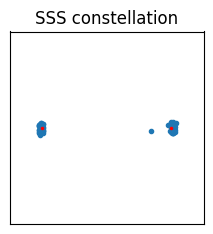

In [31]:
constellation_plot(sss_sym_demod, 'SSS constellation')

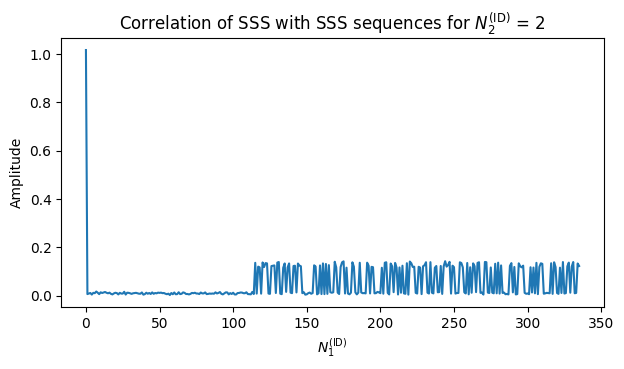

In [32]:
sss_corrs = np.empty(336, 'complex')
for j in range(sss_corrs.size):
    sss_corrs[j] = np.average(sss_sym_demod * sss_sequence(j, NID2))
plt.plot(np.abs(sss_corrs))
plt.title(f'Correlation of SSS with SSS sequences for $N^{{\mathrm{{(ID)}}}}_2$ = {nid2}')
plt.xlabel('$N^{{\mathrm{{(ID)}}}}_1$')
plt.ylabel('Amplitude');

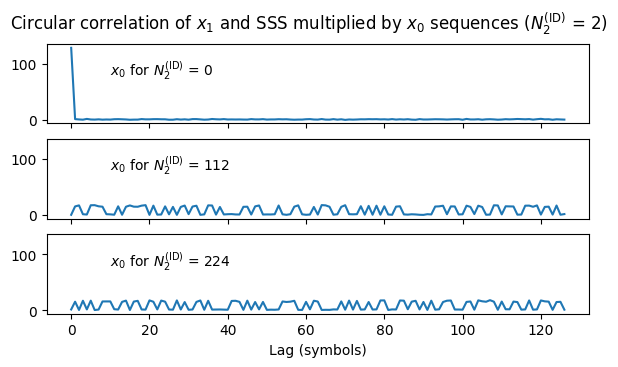

In [33]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
f_x1 = np.fft.fft(sss_sequence(0, 0, only_x1=True))
for j in range(3):
    f_sss_demod = np.fft.fft(sss_sym_demod * sss_sequence(j * 112, NID2, no_x1=True))
    corr_sss = np.fft.ifft(f_sss_demod * np.conjugate(f_x1))
    axs[j].plot(np.abs(corr_sss))
    axs[j].text(10, 80, f'$x_0$ for $N^{{\mathrm{{(ID)}}}}_2$ = {j * 112}')
plt.suptitle(f'Circular correlation of $x_1$ and SSS multiplied by $x_0$ sequences ($N^{{\mathrm{{(ID)}}}}_2$ = {nid2})')
axs[-1].set_xlabel('Lag (symbols)');

In [34]:
NID1 = 0
NcellID = 3 * NID1 + NID2
NcellID

1

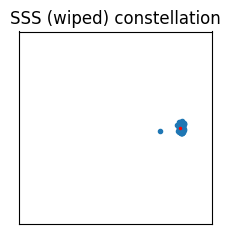

In [35]:
sss_sym_demod_wipe = sss_sym_demod * sss_sequence(NID1, NID2)

constellation_plot(sss_sym_demod_wipe, 'SSS (wiped) constellation', ref='pilot')

In [36]:
# CFO error (Hz) using PSS and SSS
((np.angle(np.average(sss_sym_demod_wipe)) - np.angle(np.average(pss_sym_demod_wipe))) / (2*np.pi) 
 * fs / (2 * (Tu + Ncp)))

-2.2820497809629847

## OFDM demodulation

In [37]:
Nsymbols = int((x.size - a0) / (1e-3 * fs) * 14)
symbols = np.empty((Nsymbols, Tu), 'complex')
t_symbols = np.empty(Nsymbols)
for j in range(Nsymbols):
    # Symbol index. Since we are starting at the PSS for j = 0,
    # which is symbol 2 mod 7, we need an offset of 2 here.
    symidx = j + 2
    off = a0 + j * (Ncp + Tu) + symidx // 7 * (Ncpl - Ncp)
    # correct for SFO
    off_err = (off - a0) * sfo + sto_fine * fs
    off_err_int = round(off_err)
    off_err_frac = off_err - off_err_int
    # Integer STO gets applied to the initial sample for OFDM demodulation
    # Fractional STO is applied as a phase slope after OFDM demodulation
    off_corr = off + off_err_int
    f = np.fft.fftshift(np.fft.fft(x[off_corr:off_corr+Tu]))
    # correct for the 5G NR upconversion discontinuity
    f *= phase_corr[symidx % 7]
    # correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
    f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*Ncp/2)
    # correct for fractional STO
    f *= np.exp(1j*2*np.pi*np.fft.fftshift(np.fft.fftfreq(Tu))*off_err_frac)
    symbols[j] = f
    t_symbols[j] = (off_corr + off_err_frac + Ncp/2) / fs

In [38]:
display(Nsymbols); display(symbols.shape); display(symbols[(0,0),(0,1)])

1877

(1877, 512)

array([-0.00252699-0.00335781j, -0.00910546+0.00136226j])

## Constellation plots

In [39]:
# PBCH DMRS sequence
issb = 0
2**11*(issb+1)*(NcellID//4 + 1) + 2**6*(issb+1) + (NcellID % 4)
display(symbols[0,0:4]);display(symbols[1,136:376][0])

array([-0.00252699-0.00335781j, -0.00910546+0.00136226j,
       -0.0038932 +0.00239442j, -0.00755348-0.01006609j])

(0.6677753257604364+0.7397207096558371j)

In [40]:
pbch_dmrs_seq = c_seq(2**11*(issb+1)*(NcellID//4 + 1) + 2**6*(issb+1) + (NcellID % 4), 288)
display(pbch_dmrs_seq[0:9]); display(len(pbch_dmrs_seq));

array([0, 0, 0, 0, 1, 1, 1, 0, 0], dtype=uint8)

288

In [41]:
pbch_dmrs_seq = 1/np.sqrt(2) * ((1 - 2*pbch_dmrs_seq[::2].astype('float'))
                                + 1j * (1 - 2*pbch_dmrs_seq[1::2].astype('float')))

In [42]:
display(pbch_dmrs_seq[0:10]); display(len(pbch_dmrs_seq));

array([ 0.70710678+0.70710678j,  0.70710678+0.70710678j,
       -0.70710678-0.70710678j, -0.70710678+0.70710678j,
        0.70710678-0.70710678j, -0.70710678-0.70710678j,
       -0.70710678-0.70710678j, -0.70710678-0.70710678j,
       -0.70710678-0.70710678j, -0.70710678-0.70710678j])

144

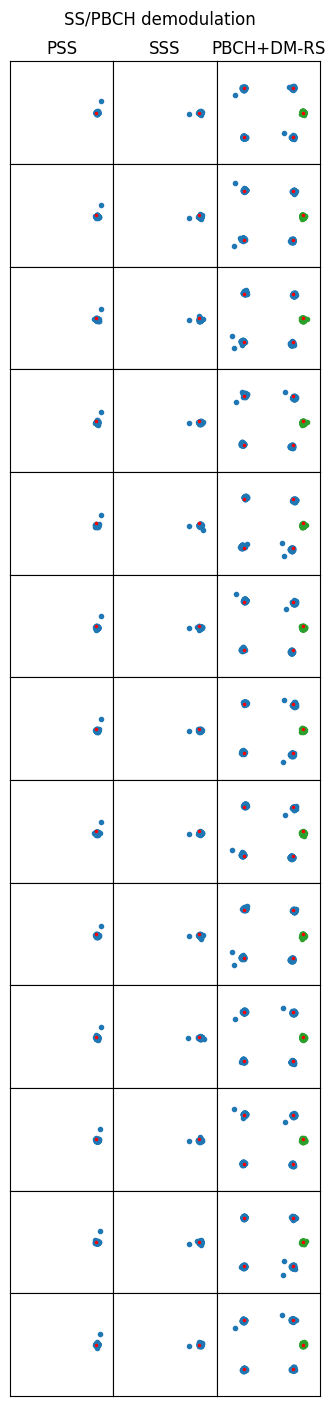

In [43]:
Nssblocks = Nsymbols // 140
plot_width = 4
fig, axs = plt.subplots(Nssblocks, 3, figsize=(plot_width, plot_width*Nssblocks/3))
for j in range(Nssblocks):
    s0 = j * 140
    pss = symbols[s0, pss_sc_sel] * pss_sequence(NID2)
    sss = symbols[s0 + 2, pss_sc_sel] * sss_sequence(NID1, NID2)
    pbch = np.concatenate([
        symbols[s0 + 1, Tu//2-120:Tu//2+120],
        symbols[s0 + 2, Tu//2-120:Tu//2-120+48],
        symbols[s0 + 2, Tu//2-120+192:Tu//2+120],
        symbols[s0 + 3, Tu//2-120:Tu//2+120],
    ])
    pbch_dmrs = pbch[NcellID % 4::4]; # display(len(pbch));display(pbch_dmrs[0]);
    pbch_dmrs_wipe = pbch_dmrs * np.conjugate(pbch_dmrs_seq)
    pbch_data = pbch[(np.arange(pbch.size) % 4) != (NcellID % 4)]
    constellation_plot(pss, ax=axs[j, 0], ref='pilot')
    constellation_plot(sss, ax=axs[j, 1], ref='pilot')
    constellation_plot(pbch_data, ax=axs[j, 2], ref='qpsk')
    constellation_plot(pbch_dmrs_wipe, ax=axs[j, 2], ref='pilot', color='C2')
plt.subplots_adjust(hspace=0, wspace=0)
plt.suptitle('SS/PBCH demodulation', y=0.91)
axs[0, 0].set_title('PSS');
axs[0, 1].set_title('SSS');
axs[0, 2].set_title('PBCH+DM-RS');

In [44]:
# CFO error (Hz) using PSS symbols 120 ms apart
(np.angle(np.average(symbols[(Nssblocks-1)*140, pss_sc_sel] * pss_sequence(NID2))) 
 - np.angle(np.average(symbols[0, pss_sc_sel] * pss_sequence(NID2)))) / (2*np.pi*10e-3*Nssblocks)

0.012763275982181995

13

array([0.0091715 , 0.01917146, 0.02917143, 0.0391714 , 0.04917137,
       0.05917134, 0.0691713 , 0.07917127, 0.08917124, 0.09917121,
       0.10917118, 0.11917114, 0.12917111])

array([-1.90005612e-11, -1.68890745e-11,  2.20842548e-10,  1.04421527e-10,
        7.07959505e-12, -3.99167145e-10,  6.64006141e-11, -5.23624051e-10,
       -9.60152654e-11,  3.75045828e-11, -3.01489638e-10,  3.70886527e-10,
       -2.64747134e-10])

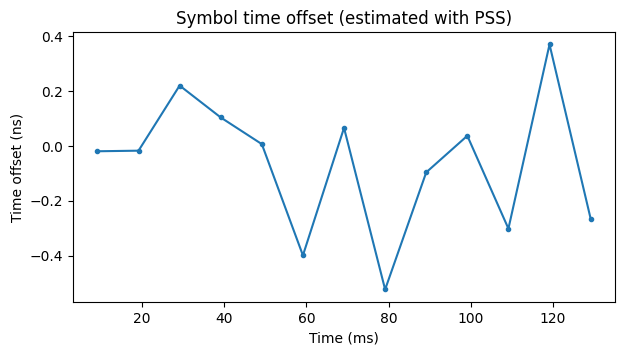

In [45]:
sto_pss_estimate = np.empty(Nssblocks)
for j in range(Nssblocks):
    sto_pss_estimate[j] = -np.polyfit(np.arange(127),
                                     np.angle(symbols[j*140, pss_sc_sel] * pss_sequence(NID2)), 1)[0] / (2 * np.pi) * Tu / fs
t_sto_pss_estimate = t_symbols[::140][:Nssblocks]
display(Nssblocks); display(t_sto_pss_estimate); display(sto_pss_estimate); 
plt.plot(1e3 * t_sto_pss_estimate, 1e9 * sto_pss_estimate, '.-')
plt.title('Symbol time offset (estimated with PSS)')
plt.xlabel('Time (ms)')
plt.ylabel('Time offset (ns)');

In [46]:
# SFO (in parts per on) and initial STO estimates
np.polyfit(t_sto_pss_estimate, sto_pss_estimate, 1)

array([-1.18479919e-09,  1.93543003e-11])

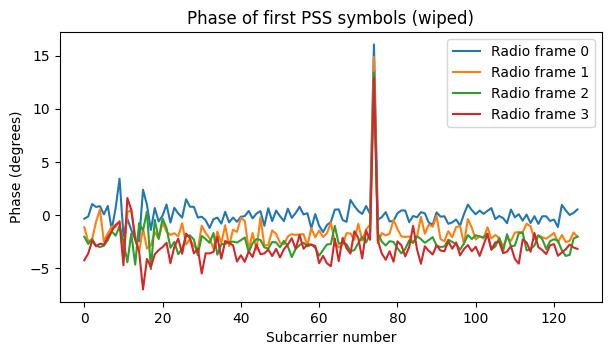

In [47]:
plt.plot(np.rad2deg(np.angle(symbols[:140*4:140, pss_sc_sel] * pss_sequence(NID2))).T)
plt.title('Phase of first PSS symbols (wiped)')
plt.xlabel('Subcarrier number')
plt.ylabel('Phase (degrees)')
plt.legend([f'Radio frame {n}' for n in range(4)]);

In [48]:
pwr_frame = np.sum(np.abs(symbols**2), axis=1)[:Nsymbols//140*140].reshape(-1, 140)
display(len(pwr_frame)); display(Nsymbols//140*140)
display(pwr_frame.shape[0]); display(type(pwr_frame));

13

1820

13

numpy.ndarray

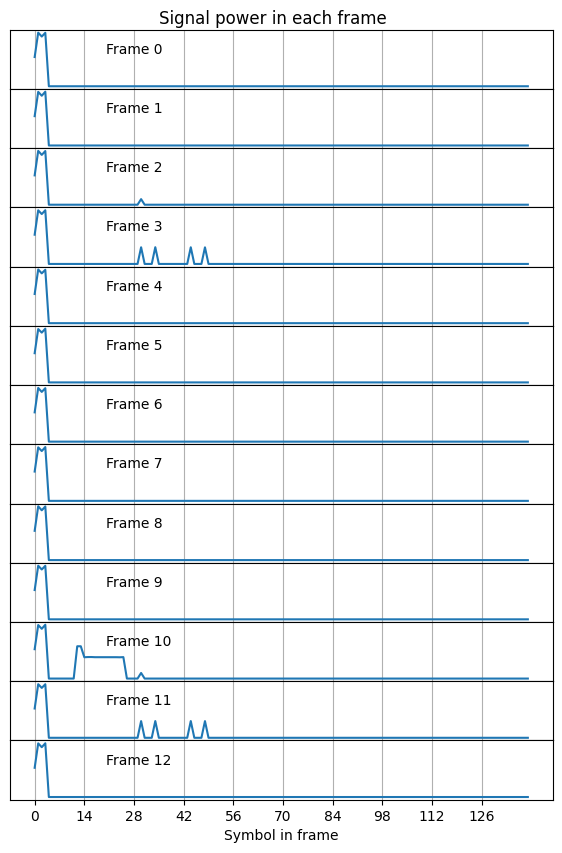

In [49]:
pwr_frame = np.sum(np.abs(symbols**2), axis=1)[:Nsymbols//140*140].reshape(-1, 140)
fig, axs = plt.subplots(13, figsize=(7, 10), sharex=True, sharey=True)
for j in range(pwr_frame.shape[0]):
    axs[j].plot(pwr_frame[j])
    axs[j].set_xticks(np.arange(0, 140, 14))
    axs[j].set_yticks([])
    axs[j].grid(axis='x')
    axs[j].text(20, 150, f'Frame {j}')
plt.subplots_adjust(hspace=0)
plt.suptitle('Signal power in each frame', y=0.90)
axs[-1].set_xlabel('Symbol in frame');

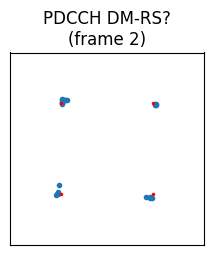

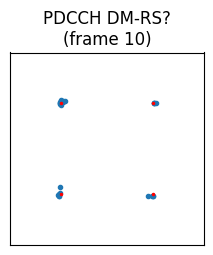

In [50]:
for k in [2, 10]:
    s = symbols[k*140+30, 127:427:12]
    constellation_plot(s, f'PDCCH DM-RS?\n(frame {k})', ref='qpsk')

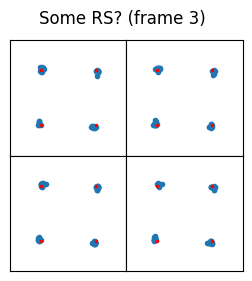

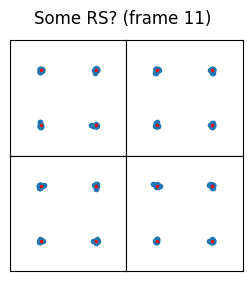

In [51]:
for k in [3, 11]:
    s = symbols[k*140+30+np.array([0, 4, 14, 18]), 116:416:4]
    fig, axs = plt.subplots(2, 2, figsize=(3, 3))
    axs = axs.ravel()
    for j in range(s.shape[0]):
        constellation_plot(s[j], ax=axs[j], ref='qpsk')
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.suptitle(f'Some RS? (frame {k})')

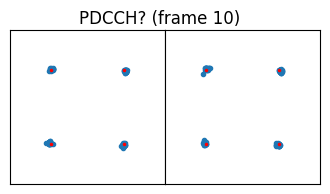

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
axs = axs.ravel()
for j in range(axs.size):
    s = symbols[10*140+12+j, np.concatenate((np.arange(164, 236), np.arange(308, 380)))]
    constellation_plot(s, ax=axs[j], ref='qpsk')
plt.subplots_adjust(hspace=0, wspace=0)
plt.suptitle('PDCCH? (frame 10)');

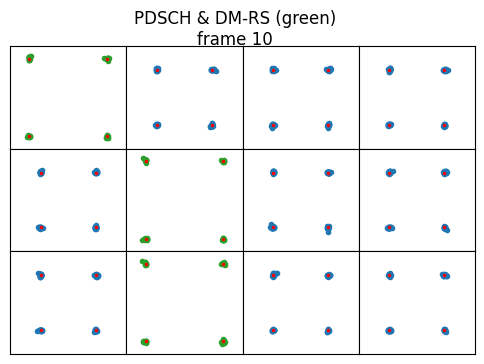

In [53]:
s = symbols[10*140+14+np.arange(12), 128:224]
fig, axs = plt.subplots(3, 4, figsize=(6, 4))
axs = axs.ravel()
for j in range(s.shape[0]):
    if j in [0, 5, 9]:
        constellation_plot(s[j, ::2], ax=axs[j], refscale=np.sqrt(2), color='C2', ref='qpsk')
    else:
        constellation_plot(s[j], ax=axs[j], ref='qpsk')
    plt.subplots_adjust(hspace=0, wspace=0)
plt.suptitle('PDSCH & DM-RS (green)\nframe 10', y=0.97);